# Diabetes Prediction Modeling
This notebook trains a machine learning model that aims to predict whether a person has prediabetes or diabetes through a variety of health indicators. The data is sourced from Kaggle, found here: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data?select=diabetes_012_health_indicators_BRFSS2015.csv

## Dependencies & Loading Data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, make_scorer, fbeta_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
import joblib
import warnings
warnings.filterwarnings('ignore', message="X does not have valid feature names")
sns.set_style('darkgrid')

In [ ]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

## Inspecting Data

The data source includes cleaned 253,680 self-reported telephone survery responses from the CDC's Behavioral Risk Factor Surveillance System (BRFSS), which collects health information across adults in the US.

In [ ]:

print("Shape: ", df.shape)
df.head()
df.info()
print("Missing values: ", df.isnull().sum())


We can see that the data has 22 columns spanning various health features. It includes the following columns:
- **Diabetes status**: 3 classes — no diabetes (0), prediabetes (1), or diabetes (2)
- **High blood pressure**: 0 = No, 1 = Yes
- **High cholesterol**: 0 = No, 1 = Yes
- **Cholesterol check**: 0 = No cholesterol check in 5 years, 1 = Yes
- **BMI**: Body Mass Index (numerical)
- **Smoking history**: 0 = Never smoked 100+ cigarettes, 1 = Has smoked
- **Stroke history**: 0 = No, 1 = Yes
- **Heart disease or attack**: 0 = No CHD or MI, 1 = Yes
- **Physical activity**: 0 = No activity in past 30 days, 1 = Yes
- **Fruit consumption**: 0 = Eats fruit <1 time/day, 1 = Eats ≥1 time/day
- **Vegetable consumption**: 0 = Eats veggies <1 time/day, 1 = Eats ≥1 time/day
- **Heavy alcohol consumption**: 0 = No, 1 = Yes (men >14/week, women >7/week)
- **Healthcare access**: 0 = No coverage, 1 = Has coverage
- **Doctor cost barrier**: 0 = Could afford, 1 = Could not see doctor due to cost
- **General health**: Self-reported: 1 = Excellent, 5 = Poor
- **Mental health days**: Days (0–30) mental health was not good (past 30 days)
- **Physical health days**: Days (0–30) physical health was not good (past 30 days)
- **Walking difficulty**: 0 = No, 1 = Serious difficulty walking/climbing stairs
- **Sex**: 0 = Female, 1 = Male
- **Age group**: 1 = 18–24, ..., 13 = 80+
- **Education level**: 1 = No schooling, ..., 6 = College graduate
- **Income level**: 1 = <$10k, ..., 8 = $75k+


## Exploratory Data Analysis


In [ ]:
# Utility functions used in EDA

def get_categorical_features(df, target="Diabetes_012"):
    """Returns a list of categorical feature column names, excluding the target."""
    cat_cols = [
        'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
        'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
        'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
        'DiffWalk', 'Sex', 'Education', 'Income', 'Age'
    ]
    
    cat_cols = [col for col in cat_cols if col != target]
    return cat_cols

def get_numerical_features(df, target="Diabetes_012"):
    """Returns a list of numerical feature column names."""
    num_cols = ['BMI', 'MentHlth', 'PhysHlth']
    num_cols = [col for col in num_cols if col != target]
    return num_cols


def get_features(df, target='Diabetes_012'):
    """Returns a list of df columns excluding the target."""
    return [col for col in df.columns if col!= target]

In [ ]:
# Plotting functions


def plot_target_distributions(df, target_feature):
    """Prints & plots the distribution of the target variable."""

    # Finds counts & percentages
    counts = df[target_feature].value_counts()
    percentages = df[target_feature].value_counts(normalize=True) * 100  
    summary = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
    print(summary)

    # Countplot
    sns.countplot(x = target_feature, data=df)
    plt.title(f"Distribution of Target: {target_feature}")
    plt.show()

def plot_feature_histograms(df, features):
    """Plot histograms for specified numerical features with a grid layout."""
    for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=(12,4))

        sns.histplot(df[feature], bins=30, ax=axes[0])
        axes[0].set_title(f"Histogram of {feature}")
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel("Count")

        sns.boxplot(x=df[feature], ax=axes[1])
        axes[1].set_title(f"Boxplot of {feature}")
        axes[1].set_xlabel(feature)

        plt.tight_layout()
        plt.show()

def plot_feature_countplots(df, features):
    """Plot countplots for categorical features."""
    for feature in features:
        sns.countplot(x=feature, data=df)
        plt.title(f"Distribution of {feature}")
        plt.show()


plot_target_distributions(df, "Diabetes_012")
plot_feature_histograms(df, get_numerical_features(df))
plot_feature_countplots(df, get_categorical_features(df))


In [ ]:

# A plot checking cholesterol and diabetes relation
def plot_chol_diabetes_relation(df):
    sns.countplot(data=df, x='HighChol', hue='Diabetes_012', palette="crest_r")
    plt.title('Diabetes Status Distribution by High Cholesterol')
    plt.xlabel('High Cholesterol')
    plt.ylabel('Count')
    plt.legend(title='Diabetes Status')
    plt.tight_layout()
    plt.show()

plot_chol_diabetes_relation(df)

### Summary
Numerical Features
- BMI: Approximately normal distribution when excluding outliers; strong right skew due to high outliers (BMI up to ~100, which is plausible in clinical data).
- Poor Mental Health Days: Right-skewed. Majority report 0 days; upper quartile around 5 days; some individuals report up to 30 days.
- Poor Physical Health Days: Similar to mental health days. Majority report 0 days; upper quartile up to about a week; outliers up to 30 days.


Categorical Features
- Age Group (binned): Dataset represents adults, with a higher proportion of middle-aged and older individuals. Younger adults are underrepresented.
- Income Group (binned): Left-skewed, with high representation of individuals earning $75k or more.
- High Blood Pressure / High Cholesterol / Smoking: Most records report "No," but a substantial minority report "Yes."
- Cholesterol Check: A small number of individuals have not had a cholesterol check in the past 5 years. "High cholesterol" values for these records should be flagged or excluded to avoid misleading results.
- History of Stroke / Heart Disease or Attack: Rare but present in a small percentage of patients.
- Physical Activity: Most individuals report physical activity in the past 30 days.
- Fruit and Vegetable Consumption: Most consume vegetables daily; fewer eat at least one fruit daily. A notable portion report not consuming either daily.
- Alcohol Consumption: The vast majority of individuals do not report heavy alcohol consumption.
- Healthcare Coverage / Doctor Affordability: The vast majority of individuals report having healthcare coverage and being able to afford medical care.
- General Health: Most commonly reported as 2 (on a 1–5 scale, with 1 being best), with a slight right skew toward poorer health.
- Serious Difficulty Walking: Small but notable minority report serious difficulty walking.
- Sex: Slight overrepresentation of females.
- Education Level: High proportion of college graduates.

The dataset represents adults, with a higher proportion of middle-aged and older individuals.

Income and education levels are skewed toward higher socioeconomic status, possibly reflecting sampling bias. The prediction model may not generalize as well to young adults or those with lower socioeconomic status due to their lower representation in the dataset.



### Outliers
There are many outliers in the distributions of BMI, poor mental health days in the past month, and poor physical health days in the past month. While uncommon, these values are likely valid- BMIs close to 100 are rare but possible, and some chronic conditions or episodes may lead to poor mental or physical health for all days in a month. Because of their clinical plausibility, we will keep these outliers rather thann remove or cap them to preserve the integrity of the dataset. However, it is important to remember that extreme values can influence certain modeling technqiues and summary statistics.

### Class Imbalance
Our dataset is highly imbalanced in the target variable, diabetes status. Approximately 84% of individuals do not have diabetes, about 14% have diabetes, and just under 2% are classified as having prediabetes. this imbalance means that the prediabetes group is very small and can easily be overlooked by predictive models if it is not handled correctly. Models trained on imbalanced data can become biased to the majority class of no diabetes, which results in poor sensitivity in detecting minority classes. Techniques like resampling and class weighting can be used during model training to mitiage the effect of the imbalance and improve detection of rare cases.


## Feature Engineering
Feature engineering to transform skewed numeric features and create interaction features.

BMI and mental/physical health days are binned to get organized categories for analysis.

Fruits and Veggies columns are combined for simplicity.

Interactoin terms are created between features that are likely to to be correlated to provide further insight.


In [ ]:
def collapse_risk(df):
        ''' Collapse the 1 & 2 signifying diabetes into risk of diabetes.'''
        df['DiabetesBinary'] = df['Diabetes_012'].replace({1: 1, 2: 1, 0: 0})
        return df



def create_features(df):
    '''
    Applies all feature engineering functions.

    Parameter: original df
    Returns: df with new features
    '''

    def total_poor_health_days(df, mental_health='MentHlth', phys_health='PhysHlth'):
        """ Creates a new total health day column by adding mental and physical days."""
        df['TotalHealthDays'] = df[mental_health] + df[phys_health]
        return df


    def bin_bmi(df, bmi_col='BMI'):
        """
        Bins BMI into its labeled categories:
        - Underweight BMI < 18.5,
        - Normal: 18.5 <= BMI < 25
        - Overweight: 25 <= BMI < 30
        - Obese: 30 <= BMI < 40
        - Extreme Obese: BMI >= 40
        """

        bmi_bins = [0, 18.5, 25, 30, 40, 200]
        bmi_labels = ['underweight', 'normal', 'overweight', 'obese', 'extreme_obese']

        # returns a series of bmi bins to apply to df
        return pd.cut(df[bmi_col], bins=bmi_bins, labels=bmi_labels, right=False)

    def bin_health_days(df, health_col):
        """Bins physical and mental health days according to severity."""
        # Include -1 to create the bin of 0 days reported
        health_bins = [-1, 0, 5, 15, 30]
        health_labels = ['none', 'mild', 'moderate', 'severe']
        return pd.cut(df[health_col], bins=health_bins, labels=health_labels)



    def create_interaction_term(df, col1, col2, new_col_name, mapping=None, drop_original=False):
        """
        Creates interaction terms between columns. 

        Parameters:
        df: the DataFrame being modified
        col1: the first original column name
        col2: the second original column name
        new_col_name: the name of the created interaction column
        mapping: a dictionary that maps values (11 -> both true)
        drop_original: boolean indicating if original column will be dropped.

        Returns the modified DataFrame.
        """
        # convert the two cols to ints rather than floating point binary
        col1_vals = pd.to_numeric(df[col1], errors='coerce').dropna().astype(int)
        col2_vals = pd.to_numeric(df[col2], errors='coerce').dropna().astype(int)

        # add the two values as a str together
        combined_vals = col1_vals.astype(str) + col2_vals.astype(str)

        # if a map is given, map the string to the output
        if mapping:
            df[new_col_name] = combined_vals.map(mapping).astype('category')
        else:
            df[new_col_name] = combined_vals.astype('category')

        if drop_original:
                df.drop([col1,col2], axis=1, inplace=True)

        return df


    # mapping
    fruit_veg_mapping = {
        '11': 'both',
        '10': 'fruit_only',
        '01': 'veg_only',
        '00': 'none'
    }

    smoke_activity_mapping = {
        '11': 'smoker_active',
        '10': 'smoker_inactive',
        '01': 'non_smoker_active',
        '00': 'non_smoker_inactive'
    }

    coverage_afford_mapping = {
        '11': 'covered_cannot_afford',
        '10': 'covered_afford',
        '01': 'uncovered_cannot_afford',
        '00': 'uncovered_afford'
    }


    # apply functions
    df = total_poor_health_days(df)
    df['bmi_bin'] = bin_bmi(df)
    df['poor_mental_health'] = bin_health_days(df,'MentHlth')
    df['poor_physical_health'] = bin_health_days(df,'PhysHlth')
    df = create_interaction_term(df, 'Fruits', 'Veggies', new_col_name='FruitVeg', mapping=fruit_veg_mapping, drop_original=True)
    df = create_interaction_term(df, 'Smoker', 'PhysActivity', new_col_name='SmokeActivity', mapping=smoke_activity_mapping)
    df = create_interaction_term(df, 'AnyHealthcare', 'NoDocbcCost', new_col_name='HealthAccess', mapping=coverage_afford_mapping, drop_original=True)
    df = collapse_risk(df)

    return df

# apply feature engineering
df = create_features(df)

Since this project involves healthcare data, model interpretability is an important consideration. Using an interpretable model helps both patients and healthcare providers understand the main factors driving diabetes risk, which can guide more informed decisions about lifestyle changes and treatment options. For instance, identifying that high BMI or low physical activity are strong risk factors can support targeted interventions. Furthermore, it is important to be able to trust any health decisions generated by a model, and black box models can create obstacles in this due to lack of transperency. However, if the goal is simply to accurately identify individuals at risk for further screening, then interpretability may be less of a priority. 

The dataset is very imbalanced, specifically for prediabetes. There are many methods to address this, including undersampling the dominant classes, oversampling the smaller classes through techniques like SMOTE, or using class weights. Over/undersampling adds an exra step in the preprocessing stage, and comes with either losing data or relying on syntehtic data, which can add noise or overfit to training sets. Additionally, modern models such as LightGBM or XGBoost that are able to handle class imbalances better. When evaluating models, its also more important to look at f1, precision, and recall, as accuracy alone could be misleading if it is completely missing the minority class. Choosing a LightGBM or XGBoost model could help with the class imbalance without the risks of losing data or using synthetic data points. However, it comes with less interprebility than simpler models. Using SHAP values can help us evaluate feature importance.

For simplicity in this project, we will collapse prediabtetes and diabetes into one category in order to provide an idea of risk levels.

## Baseline Model
We begin with a baseline model to set a minimum expectation for a more complex model's performance and for interprebility. We choose to use a logistic regression model for its simplicity and speed.

In [ ]:
def split_cols(df, ignore_chol=False):
    '''
    Returns the columns of the df as three lists for preprocessing: numerical, binary, and categorical.
    ignore_chol is added to evaluate effects of potential data leakage later in the notebook.
    '''

    num_cols = [c for c in ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'TotalHealthDays'] if c in df.columns]
    if not ignore_chol:
        binary_cols = [c for c in ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                   'PhysActivity', 'HvyAlcoholConsump', 'DiffWalk', 'Sex'] if c in df.columns]
    else:
        binary_cols = [c for c in ['HighBP', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                   'PhysActivity', 'HvyAlcoholConsump', 'DiffWalk', 'Sex'] if c in df.columns]
    
    cat_cols = [c for c in ['bmi_bin', 'FruitVeg', 'SmokeActivity', 'HealthAccess', 'poor_mental_health', 'poor_physical_health'] if c in df.columns]
    return num_cols, binary_cols, cat_cols


In [ ]:

def baseline_model_pipeline(df):
    '''
     Prepares a logistic regression pipeline and returns features and target for diabetes risk prediction.

    - Collapses the multi-class diabetes indicator into a binary target (diabetes risk).
    - Identifies numerical, binary, and categorical feature columns.
    - Builds a pipeline that preprocesses features appropriately (scaling, one-hot encoding, passthrough).
    - Sets up a logistic regression classifier with class balancing.

    Returns:
    clf: The model pipeline with preprocessing and logistic regression classifier.
    X:  The feature dataframe after dropping target columns.
    y:  The binary target variable indicating diabetes risk.

    '''

    # collapsing the risk for the model, 
    df = collapse_risk(df)

    # splitting columns
    num_cols, binary_cols, cat_cols = split_cols(df)


    # defining train and test
    X = df.drop(columns=['Diabetes_012', 'DiabetesBinary'])
    y = df['DiabetesBinary']


    preprocessor = ColumnTransformer(transformers=[
        # standardize numerics, leave binaries as is, onehot encode categorical
        ('num', StandardScaler(), num_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ], remainder='drop')

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ])

    return clf, X, y




def evaluate_model(clf, X, y, cv=5, threshold=.5):
    '''
    Evaluates model accuracy through metrics and confusion matrix.

    Parameters:
    - clf: The classifier model pipeline
    - X: The feature dataframe after dropping target columns.
    - y: The binary target variable indicating diabetes risk.
    - cv: num cv folds
    - threshold: threshold for converting prebabilities to predictions.

    Prints metrics, no returns.
    '''

    # Using stratified K-folds for even cross validation
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # finding cv probabilities, then converting to binary predict w/ given threshold
    y_probs = cross_val_predict(clf, X, y, cv=stratified_cv, method='predict_proba')
    y_pred = (y_probs[:,1] >= threshold).astype(int)

    # calculate scoring metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    
    # Get cross-validated predictions for confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # print classification report
    print(classification_report(y, y_pred, target_names=['No Diabetes', 'Diabetes']))

    precision, recall, _ = precision_recall_curve(y, y_probs[:, 1])
    avg_prec = average_precision_score(y, y_probs[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (AP = {avg_prec:.2f})', color='purple')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:

def run_baseline_model(df):
    base_clf, base_X, base_y = baseline_model_pipeline(df)
    evaluate_model(base_clf, base_X, base_y)
run_baseline_model(df)

The baseline regression model has an accuracy of .73, but the F1 is only .47. This is because the recall is .77, meaning that the model caches about 77% of actual diabetes cases, but has a precision of .34, meaning that it when it predicts diabetes, it is only correct about 34% of the time, meaning that there are many false positives. The accuracy is heavily influenced by the majority class size. While the accuracy might look like a decent baseline, the F1 score shows how the imbalance in data can make that metric misleading; it is essential to look at other scores.

## Second Model
The logistic regression model can be improved with hyperparamter tuning or different feature engineering, but it is not ideal for handling imbalanced data. Tree-based models like LIghtGBM and XGBoost can handle imbalanced data better and capture nonlinear relationships that logistic regression often misses. Using these models can provide a boost in performance with less manual tuning or changes in feature engineering.

LightGBM will be used as it is fast and efficient on larger datasets like this one. While interpretability matters here, LightGBM lets us use tools like SHAP values to understand whcih features drive the model's predictions, making results more transparent and trustworthy in a medical context.

In [ ]:
def lgbm_model_pipeline(df, ignore_chol=False):
    '''
    Prepares a LightGBM pipeline and returns features and target.
    - Collapses multi-class indicator into binary diabetes risk target
    - Builds a pipeline that scales and encodes features 
    - Sets up the LightGBM classifier

    Returns:
    clf: the model pieline with preprocessing and LightGBM classifier
    X: the feature dataframe after dropping target
    y: the binary target of diabetes risk
    
    '''

    df = collapse_risk(df)
    num_cols, binary_cols, cat_cols = split_cols(df, ignore_chol)

    X = df.drop(columns=['Diabetes_012', 'DiabetesBinary'])
    y = df['DiabetesBinary']

    # ignore cholestorel from training if true & if they exist in df
    if ignore_chol:
        chol_cols = ['HighChol', 'CholCheck']
        cols_to_drop = [col for col in chol_cols if col in X.columns]
        if cols_to_drop:
            X = X.drop(columns=cols_to_drop)

        
    # handling imbalance by creating a weight
    neg_count = sum(y == 0)
    pos_count = sum(y == 1)
    scale_pos_weight = neg_count / pos_count
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ], remainder = 'drop')

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(random_state=42, verbose = -1, scale_pos_weight=scale_pos_weight))
    ])

    return clf, X, y


def run_base_lgbm(df):
    lgbm_clf, lgbm_X, lgbm_y = lgbm_model_pipeline(df)
    evaluate_model(lgbm_clf, lgbm_X, lgbm_y)
    return lgbm_clf, lgbm_X, lgbm_y

lgbm_clf, lgbm_X, lgbm_y = run_base_lgbm(df)





This model has improved recall, but still struggles with precision. In order to achieve a better F1, we will tune the hyperparameters. We use a randomized search to do this. An SHAP explainer is also set up for later evaluation.

In [ ]:

# SHAP for model analysis
def get_shap_explainer(clf_pipeline, X, sample_size=15000):
    ''''
    Generates SHAP values for the given pipelne and input features.

    Parameters:
    clf_pipeline: fitted pipeline (preprocessing & LightGBM classifier)
    X: feature input
    sample_size: n samples to use for SHAP set to 1k for speed

    '''
    # sample feature data for speed
    X_sample = X.sample(n=min(sample_size,len(X)), random_state=42)

    # extract steps of lgbm pipeline
    model = clf_pipeline.named_steps['classifier']
    preprocessor = clf_pipeline.named_steps['preprocessor']

    # process feature input and collect names
    X_processed = preprocessor.transform(X_sample)
    feature_names = preprocessor.get_feature_names_out()

    # compute SHAP
    explainer = shap.Explainer(model, X_processed, feature_names=feature_names)
    shap_vals = explainer(X_processed)
    shap.summary_plot(shap_vals, X_processed, feature_names=feature_names)


def randomized_search_lgbm_pipeline(clf, X, y, param_dis, n_iter=50, cv=5, scoring='f1'):
    '''
    Performs Randomized Search CV on the LightGBM pipeline.

    Parameters:
    clf: the LightGBM pipeline
    X: features
    y: target 
    param_dis: paramtetres to search over
    n_iter: num parameter settings sampled
    cv: number of cv folds
    scoring: metric to optimize by

    Returns: 
    best_model: model with best found parameters
    cv_results: results of the grid search
    '''


    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dis, n_iter=n_iter, scoring=scoring, cv=stratified_cv, n_jobs=-1, refit=True, random_state=42)

    random_search.fit(X, y)

    print(f"Best {scoring} score: {random_search.best_score_:.4f}")
    print(f"Best Parameters: {random_search.best_params_}")

    best_model = random_search.best_estimator_
    cv_results = random_search.cv_results_

    return best_model, cv_results


# setting a paramter grid based on commonly tested values for LightGBM tuning & imbalance ration
param_grid = {
    'classifier__num_leaves': [31, 50, 100],
    'classifier__learning_rate': [0.005, 0.01, 0.05],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__scale_pos_weight': [1, 5, 5.7, 6] 
}


In [ ]:
# creates a f2 score to prioritize recall
f2_scorer = make_scorer(fbeta_score, beta=2)

# line below finds hyperparams. commented out to avoid accidental repeat evaluation
# best_model, cv_results = randomized_search_lgbm_pipeline(lgbm_clf, lgbm_X, lgbm_y, param_grid, n_iter=50, cv=5, scoring=f2_scorer)


The output from randomized search gives us the best parameters for F2 in this model, which addresses precision and recall with emphasis on recall. We assign  the updated parameters to the LightGBM classifier for future use.

In [ ]:
# set tuned hyperparamters
def set_best_params(lgbm_clf):
    '''Sets the params to the classifier part of the pipeline. Values hardcoded from RandomizedSearchCV.'''
    best_params = {'scale_pos_weight': 6, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05}
    lgbm_clf.named_steps['classifier'].set_params(**best_params)
    return lgbm_clf


We can also find the best threshold for the calculated probabilities.

In [ ]:

def find_best_threshold(model, X_val, y_val,beta=2):
    '''
    Finds the best classification threshold to maximize the default F2 score.

    model: the fitted pipeline 
    X_val: validation features
    y_val: validation labels
    beta: F-beta score, default of 2
    '''
    y_probs = model.predict_proba(X_val)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

    beta_sq = beta ** 2

    # F2 is calculated w/ avoiding dividing by 0
    fbeta_scores = np.divide(
        (1 + beta_sq) * precisions * recalls,
        (beta_sq * precisions) + recalls,
        out=np.zeros_like(precisions),
        where=((beta_sq * precisions) + recalls) != 0
    )

    fbeta_scores = fbeta_scores[:-1]
    thresholds = thresholds

    best_i = fbeta_scores.argmax()
    best_threshold = thresholds[best_i]
    print(f"Best threshold: {best_threshold:.2f} with F2 of {fbeta_scores[best_i]:.2f}")
    return best_threshold



In [ ]:

# find the best threshold
def tuned_model(lgbm_clf, lgbm_X, lgbm_y, run_shap=True):
    '''Sets best parameters, fits the model to data, finds best threshold, & evaluates the model. '''
    X_train, X_val, y_train, y_val = train_test_split(lgbm_X, lgbm_y, test_size=0.2, stratify=lgbm_y, random_state=42)
    lgbm_clf = set_best_params(lgbm_clf)
    lgbm_clf.fit(X_train, y_train)
    best_thresh = find_best_threshold(lgbm_clf, X_val, y_val)
    evaluate_model(lgbm_clf, X_val, y_val, threshold=best_thresh)
    if run_shap:
        get_shap_explainer(lgbm_clf, X_train)



tuned_model(lgbm_clf, lgbm_X, lgbm_y,run_shap=False)

From this, we can see that the ideal threshold will be .42 instead of the default .5, which provides a small boost in F2 score. The model can now be evaluated again with the new parameters and threshold. We observe a noticeable improvement in recall for diabetes, which has increased to .85 from the previous score of .79. However, precision has lowered from .33 to .30.  While the model catches more of the true diabetes cases, overall accuracy has decreased.

### SHAP Interpretation
The features with largest impact on the model's diabetes risk prediction were self reported general health, age, presence of high blood pressure, BMI, and presence of high cholestorol. Income has a substansial effect, which could point towards healthcare accessibility. Heavy alcohol consumption is likely a confounding variable, as it is associated with lower risk.

## Further LightGBM adjustments
An ensemble stacking the LightGBM and logistic regression model is used to check for any boost in prediction.

In [ ]:
# trying ensemble to see if it provides a boost

def stack_pipeline(df):
    logreg_clf, X, y = baseline_model_pipeline(df)
    lgbm_clf, _, _ = lgbm_model_pipeline(df)
    lgbm_clf = set_best_params(lgbm_clf)


    stacking_clf = StackingClassifier(
        estimators=[
            ('logreg', logreg_clf),
            ('lgbm', lgbm_clf)
        ],
        final_estimator=LogisticRegression(max_iter=1000, class_weight={0:1, 1:4}),
        cv=5,
        n_jobs=-1
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    stacking_clf.fit(X_train, y_train)
    # adding .03 to best_thres to slightly boost precision
    best_thresh = find_best_threshold(stacking_clf, X_val, y_val) +.03
    evaluate_model(stacking_clf, X_val, y_val, threshold=best_thresh)

stack_pipeline(df)


Stacking the two models were already built did not provide a signficant increase in F1, and is not worth the added complexity. While the metrics for logistic regression and LightGBM were not all the same, there is not a dramatic enough difference in the two for stacking to provide further insight.

One notable concern is potential data leakage from the cholesterol check feature. Individuals with a diabetes diagnosis are often encouraged to monitor cholesterol levels more frequently. If cholesterol check frequency is captured post-diagnosis, the model may learn patterns of disease management rather than risk indicators. RBecause the model is intended for pre-diagnosis risk prediction, removing this feature may be necessary to ensure valid learning. The final model will remove the predictors of cholesterol check or high cholesterol, which may reduce F1 but provide a more accurate generalization.

Best threshold: 0.46 with F2 of 0.62
Accuracy: 0.6809957426679281
F1 Score: 0.44808184143222507
Precision: 0.3080168776371308
Recall: 0.8217636022514071


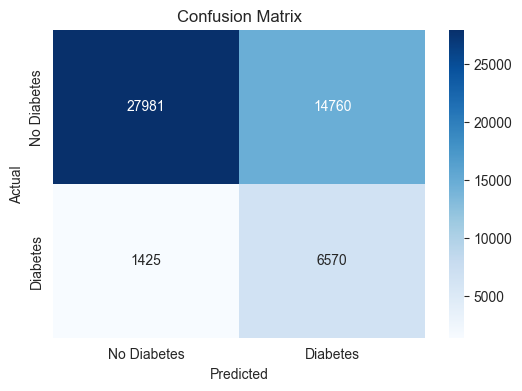

              precision    recall  f1-score   support

 No Diabetes       0.95      0.65      0.78     42741
    Diabetes       0.31      0.82      0.45      7995

    accuracy                           0.68     50736
   macro avg       0.63      0.74      0.61     50736
weighted avg       0.85      0.68      0.72     50736



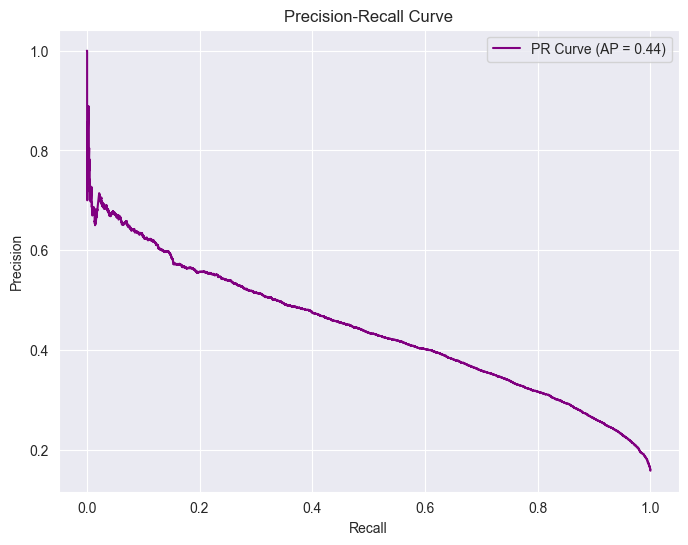

In [26]:
# Evaluating the model without chol features
def run_no_chol(df, run_shap=True):
    clf, X, y = lgbm_model_pipeline(df, ignore_chol=True)
    # get train test split labels
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    clf = set_best_params(clf)
    clf.fit(X_train, y_train)
    best_thresh = find_best_threshold(clf, X_val, y_val)
    evaluate_model(clf, X_val, y_val, threshold=best_thresh)
    if run_shap:
        get_shap_explainer(clf, X_train, sample_size=20000)
    return clf

# shap saved as a png
final_clf = run_no_chol(df, run_shap=False)


# Final Evaluation and Future Notes

This model is designed to flag likely cases of diabetes, prioritizing high recall to avoid missing true positives. A recall of 0.82 was achieved, with a precision of only around 0.31. While this lowers the F1 score, it aligns with the goal of screening rather than diagnosis. In real-world applications, whether the model aims to detect all at-risk individuals, confirm diagnoses, or support clinical decisions would inform which evaluation metric to prioritize. This model has room for improvement in its detection, especially in precision, as it sets off many false alarms. While it can find the majority of true cases, the presence of false positives lowers trust in the model's predictions. It would provide insight to individuals who may be concerned about their risk level and want to check if they should consider speaking to a doctor about it. 

The model’s performance is based on this specific dataset, which, while large, may not fully represent all demographic groups. For example, older adults are overrepresented, and the dataset skews toward individuals with higher socioeconomic status. SHAP analysis suggests that lower income is treated by the model as a risk signal. This could reflect confounding factors like nutrition quality or healthcare access, but might also stem from sampling bias or underlying disparities in data collection. More diverse, representative data would improve generalizability across populations.

Given the healthcare context and the serious implications of missing true cases, increasing recall at the expense of precision is a justifiable tradeoff. Future improvements may focus on increasing recall further while gradually improving precision through techniques such as more refined feature engineering, additional external data, or advanced ensemble methods.

## Saving model
The final LightGBM model pipeline, trained without cholesterol features to ensure there is no leakage, is saved using joblib. The file includes the preprocessing pipeline, so it can be used for future prediction without refitting transformers. However, as some feature engineering was done before the pipeline was created, input data would have to undergo those steps as well in order to match the model's input.


In [ ]:

joblib.dump(final_clf, 'diabetes_model_pipeline.pkl')